# Transformers and Multi-Head Attention

Depuis la publication de l'article [Attention Is All You Need](https://arxiv.org/abs/1706.03762) de Vaswani et al. en 2017, l'architecture Transformer a continué à battre des benchmarks dans de nombreux domaines, en particulier dans le traitement du langage naturel. Dans ce notebook, nous allons voir comment la mettre en oeuvre soi-même.
Nous avons déjà vu lors de notre présentation la mise en oeuvre des transformers pour la traduction, nous allons ici les appliquer à un tout autre domaine : la classification d'images.

In [1]:
## Importations des librairies standardes
import os
import numpy as np 
import random
import math
import json
from functools import partial

## Importations pour la visualisation d'images 
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm pour les loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# chemin vers le fichier où les datasets seront téléchargés
DATASET_PATH = "C:/Users/morga/Documents/CN/Cours/DEEP/pres/data"
# chemin vers le fichier où les modèles pré-entraînés seront enregistrés
CHECKPOINT_PATH = "C:/Users/morga/Documents/CN/Cours/DEEP/pres/saved_models/tutorial6"


# Seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

C:\Users\morga\AppData\Local\Temp\ipykernel_252\1484270656.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cpu


<Figure size 640x480 with 0 Axes>

On télécharge deux modèles pré-entraînés :

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL où les modèles sont stockés
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Fichiers à télécharger
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Création du chemin si inexistant
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# Téléchargement si pas déjà fait
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Erreur de téléchargement")

## L'architecture Transformer

Nous allons implémenter l'architecture d'un transformer à la main. Cependant, il existe un module Pytorch pré-fait `nn.Transformer` ([documentation](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)) et un [tutoriel](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) associé.


### Calcul de l'attention

Q : matrice de querys

K : matrice de keys

V : matrice de values

L'attention est calculée comme suit :

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Voici la fonction qui permet de calculer l'attention :

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

### Multi-Head Attention


$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$


In [5]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [6]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        if mask is not None:
            mask = expand_mask(mask)
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

### Transformer Encoder

Architecture du transformer :

<center width="100%"><img src="transformer_architecture.svg" width="400px"></center>

L'encoder consiste en $N$ blocks identiques appliqués en séquence. L'entrée est d'abord passée dans le bloc Multi-Head Attention implémenté plus haut. Puis, la sortie de ce bloc est ajoutée à l'entrée d'origine, puis la somme est normalisée. 

Après cela, on applique un multilayer perceptron (MLP)(partie Feed-Forward) pour préparer l'information d'entrée du bloc MLP au prochain bloc de Multi-Head Attention. 

On commence par encoder un seul bloc d'encoder :

In [7]:
class EncoderBlock(nn.Module):
    
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()
        
        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
        
        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        
        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        
        return x

On implémente maintenant l'encoder complet avec N bloc d'encoder définis plus haut. On ajoute une fonction `get_attention_maps` qui retourne les probabilités d'attention de tout les blocs Multi-Head Attention pour mieux comprendre le modèle.

In [8]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional encoding

Le bloc Multi-Head Attention ne peut pas distinguer si une entrée vient avant une autre dans la séquence ou non. Cependant, dans des tâches telles que la compréhension du langage, la position est importante pour l'interprétation des mots d'entrée. L'information sur la position peut donc être ajoutée via les caractéristiques de l'entrée. 

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ représente l'encoding de la position $pos$ dans la séquence, et la dimension cachée $i$.

In [9]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model) 
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

### Learning rate warm-up

Une technique commune pour entraîner un transformer est le learning rate warm-up. Le learning rate est augmenté graduellement de 0 à une valeur choisie lors des premières itérations. Sans cette technique, le modèle peut diverger et être bien moins performant, par exemple dans cette figure qui compare comparing Adam-vanilla (sans warm-up) vs Adam-warmup (avec warm-up) ([Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf)) :

<center width="100%"><img src="warmup_loss_plot.svg" width="350px"></center>

Nous utilisons un cosine warm-up scheduler, qui combine le warm-up avec une décroissance du learning rate en forme de cosinus (voir figure `cosine warm-up learning rate scheduler`. 

In [12]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)
        
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

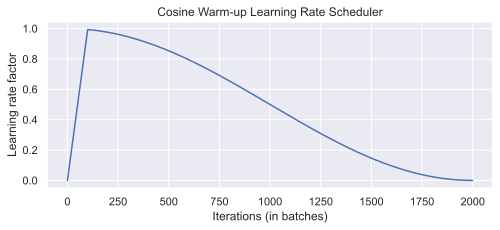

In [13]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

Dans les 100 premières itérations, nous augmentons le facteur du taux d'apprentissage de 0 à 1, tandis que pour toutes les itérations suivantes, nous le diminuons en utilisant la forme d'un cosinus. Des pré-implémentations de ce planificateur peuvent être trouvées dans la bibliothèque populaire NLP Transformer.

### PyTorch Lightning Module

Enfin, nous pouvons intégrer l'architecture Transformer dans un module PyTorch Lightning. 
En plus de l'architecture du transformateur, nous ajoutons un petit réseau d'entrée (qui fait correspondre les dimensions d'entrée aux dimensions du modèle), le positionnal encoding, et un réseau de sortie (qui transforme les codages de sortie en prédictions). Nous ajoutons également le cosine warm-up scheduler, qui prend une mesure à chaque itération au lieu d'une fois par epoch. L'étape de training, de validation et de test est laissée vide pour l'instant et sera remplie pour nos modèles spécifiquement aux tâches.

In [14]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        ) 

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        
        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer, 
                                             warmup=self.hparams.warmup, 
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError    

    def test_step(self, batch, batch_idx):
        raise NotImplementedError   

## Experiences

Nous allons maintenant expérimenter sur le Transformer que nous avons créé.

### Sequence to Sequence

Une tâche Sequence-to-Sequence est une tâche dans laquelle l'entrée est une séquence, et la sortie est une séquence (par exemple, de la traduction). Nous allons montrer en quoi le transformer est efficace pour ce genre de tâche, avec un exemple très simple, qui consiste à inverser une séquence de chiffre (c'est à dire, pour un entrée $x$, renvoyer $x$[::-1]). Même si cette tâche peut paraître très simple, les RNNs peuvent avoir des difficultés à les effectuer parce que la tâche requiert de la mémoire long terme. Les transformers sont crées pour cette raison, donc devraient avoir de très bonnes performances sur cette tâche.

Création du dataset :

In [15]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        
        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))
  
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

On crée des séquences de nombres entre 0 et `num_categories-1`. Le label est la séquence renversée.

In [16]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

Voici une exemple de donnée :

In [17]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


Pendant le training, nous faisons passer la séquence d'entrée par l'encodeur du Transformer et prédisons la sortie pour chaque jeton d'entrée. Pour ce faire, nous utilisons la perte "Cross-Entropy loss". Chaque nombre est représenté sous la forme d'un "one-hot vector".

In [18]:
class ReversePredictor(TransformerPredictor):
    
    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()
        
        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        
        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc
        
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

Enfin, nous pouvons créer une fonction de training. Nous créons un objet `pl.Trainer`, qui s'exécute pendant $N$ epochs, se connecte à TensorBoard, et enregistre le meilleur modèle basé sur la validation. Ensuite, nous testons nos modèles sur l'ensemble de test. Un paramètre supplémentaire que nous passons au trainer ici est `gradient_clip_val`. Ce paramètre écrête la norme des gradients pour tous les paramètres avant d'entreprendre une étape d'optimisation et empêche le modèle de diverger si nous obtenons des gradients très élevés. Pour les Transformers, l'écrêtage de gradient peut aider à stabiliser davantage l'apprentissage pendant les premières itérations, et aussi par la suite. Dans PyTorch, on peut appliquer l'écrêtage de gradient via `torch.nn.utils.clip_grad_norm_(...)` (voir [documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html#torch.nn.utils.clip_grad_norm_)). La valeur de clip est généralement comprise entre 0.5 et 10, en fonction de la sévérité avec laquelle on souhaite écrêter les grands gradients. 

Voici la fonction de training :

In [19]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir, 
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         gradient_clip_val=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)
        
    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}
    
    model = model.to(device)
    return model, result

Enfin, nous pouvons entraîner le modèle. Dans cette configuration, nous utiliserons un seul bloc d'encodage et une seule tête dans l'attention multi-têtes. Ce choix s'explique par la simplicité de la tâche et, dans ce cas, l'attention peut être interprétée comme une "explication" des prédictions.

In [20]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Found pretrained model, loading...


Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\morga\Documents\CN\Cours\DEEP\pres\saved_models\tutorial6\ReverseTask.ckpt`
Missing logger folder: C:\Users\morga\Documents\CN\Cours\DEEP\pres\saved_models\tutorial6\ReverseTask\lightning_logs
C:\Users\morga\Documents\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

In [21]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


Comme attendu, le Transformer exécute correctement cette tâchr. Nous allons visualiser l'attention dans le bloc Multi-Head Attention pour une donnée arbitraire :

In [6]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

NameError: name 'val_loader' is not defined

L'objet `attention_maps` est une liste de taille $N$ où $N$ est le nombre de couches du Transformer.

Voici une fonction de traçage qui prend en entrée les séquences, les cartes d'attention et un index indiquant pour quel élément du dataset nous voulons visualiser la carte d'attention. Nous allons créer un graphique où, sur les lignes, nous aurons différentes couches, tandis que sur les colonnes, nous montrerons les différentes têtes. Le softmax a été appliqué à chaque ligne séparément.

In [24]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]
    
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

Voici la carte d'attention pour la tâche d'inversion de séquence de chiffres :

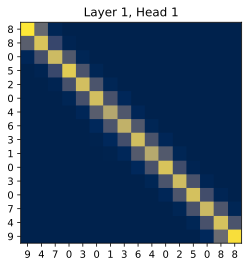

In [25]:
plot_attention_maps(data_input, attention_maps, idx=0)

The model has learned to attend to the token that is on the flipped index of itself. Hence, it actually does what we intended it to do. We see that it however also pays some attention to values close to the flipped index. This is because the model doesn't need the perfect, hard attention to solve this problem, but is fine with this approximate, noisy attention map. The close-by indices are caused by the similarity of the positional encoding, which we also intended with the positional encoding.
Le modèle a appris à s'intéresser au token qui se trouve sur l'inverse de son index (inverse dans le sens de notre tâche actuelle). Il a donc appris correctement. Nous constatons toutefois qu'il accorde également une certaine attention aux valeurs proches de l'indice inversé. Cela s'explique par le fait que le modèle n'a pas besoin d'une attention parfaite pour résoudre ce problème, mais qu'il s'accommode de cette carte d'attention approximative et bruyante. Les indices proches sont dus à la similarité de l'encodage positionnel, ce qui est une caractéristique voulue de celui-ci.

### Détection d'anomalie

Besides sequences, sets are another data structure that is relevant for many applications. In contrast to sequences, elements are unordered in a set. RNNs can only be applied on sets by assuming an order in the data, which however biases the model towards a non-existing order in the data. [Vinyals et al. (2015)](https://arxiv.org/abs/1511.06391) and other papers have shown that the assumed order can have a significant impact on the model's performance, and hence, we should try to not use RNNs on sets. Ideally, our model should be permutation-equivariant/invariant such that the output is the same no matter how we sort the elements in a set. 
Outre les séquences, les ensembles constituent une autre structure de données pertinente pour de nombreuses applications. Contrairement aux séquences, les éléments d'un ensemble ne sont pas ordonnés. Les RNN ne peuvent être appliqués aux ensembles qu'en supposant un ordre dans les données, ce qui biaise le modèle. Les Transformers, grâce au principe d'attention, ne subissent pas ce biais.

La tâche ici est de détecter l'anomalie parmi un ensemble d'image. Nous utilisons pour cela le dataset CIFAR100. Nous montrerons au model 9 images d'un classe, et 1 d'une autre classe, le but étant pour lui de détecter quelle image appartient à une classe différente que les autres.

<center width="100%" style="padding:20px"><img src="cifar100_example_anomaly.png" width="600px"></center>


Nous utiliserons un modèle ResNet34 pré-entraîné provenant du paquetage torchvision. Le modèle ResNet a été pré-entraîné sur l'ensemble de données [ImageNet] (http://image-net.org/) qui contient 1 million d'images de 1k classes et de différentes résolutions. Cependant, lors de l'entraînement et des tests, les images sont généralement mises à l'échelle à une résolution de 224x224, et nous remettons donc à l'échelle nos images CIFAR à cette résolution également. Ci-dessous, nous allons charger l'ensemble de données et préparer les données à être traitées par le modèle ResNet.

In [26]:
# ImageNet statistics
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
# As torch tensors for later preprocessing
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)

# Resize to 224x224, and normalize to ImageNet statistic
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset. 
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

100%|██████████| 169001437/169001437 [00:33<00:00, 5030097.83it/s]


Extracting C:/Users/morga/Documents/CN/Cours/DEEP/pres/data\cifar-100-python.tar.gz to C:/Users/morga/Documents/CN/Cours/DEEP/pres/data
Files already downloaded and verified


Ensuite, nous voulons exécuter le modèle ResNet pré-entraîné sur les images et extraire les features avant la couche de classification. Il s'agit des caractéristiques de plus haut niveau, qui devraient décrire suffisamment les images. Le CIFAR100 présente une certaine similitude avec ImageNet, et nous ne réentraînons donc pas le modèle ResNet sous quelque forme que ce soit. Toutefois, si vous souhaitez obtenir les meilleures performances et disposer d'un très grand ensemble de données, il serait préférable d'ajouter le ResNet au graphe de calcul pendant l'apprentissage et d'ajuster ses paramètres. Comme nous ne disposons pas d'un ensemble de données suffisamment important et que nous voulons entraîner notre modèle efficacement, nous allons extraire les caractéristiques au préalable. Chargeons et préparons le modèle ci-dessous.

In [27]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
# Remove classification layer
# In some models, it is called "fc", others have "classifier"
# Setting both to an empty sequential represents an identity map of the final features.
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval, no gradient required
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:/Users/morga/Documents/CN/Cours/DEEP/pres/saved_models/tutorial6\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:16<00:00, 5.45MB/s]


Téléchargez ces fichiers [GoogleDrive folder](https://drive.google.com/drive/folders/1DF7POc6j03pRiWQPWSl5QJX5iY-xK0sV?usp=sharing) dans le fichier indiqué par CHECKPOINT_PATH (déterminé dans la première cellule du notebook)

In [42]:
@torch.no_grad()
def extract_features(dataset, save_file):
#    if not os.path.isfile(save_file):
#        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
#        extracted_features = []
#        for imgs, _ in tqdm(data_loader):
#            imgs = imgs.to(device)
#            feats = pretrained_model(imgs)
#            extracted_features.append(feats)
#        extracted_features = torch.cat(extracted_features, dim=0)
#        extracted_features = extracted_features.detach().cpu()
#        torch.save(extracted_features, save_file)
#    else:
    extracted_features = torch.load(save_file)
    return extracted_features

#train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_feat_file = CHECKPOINT_PATH + "/train_set_features.tar"
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = CHECKPOINT_PATH + "/test_set_features.tar"
test_feats = extract_features(test_set, test_feat_file)

In [43]:
print("Train:", train_set_feats.shape)
print("Test: ", test_feats.shape)

Train: torch.Size([50000, 512])
Test:  torch.Size([10000, 512])


séparation entre 90% de data pour le training, et 10% pour la validation. Cependant, la difficulté réside dans le fait que nous devons nous assurer que l'ensemble de validation comporte le même nombre d'images pour les 100 étiquettes. Dans le cas contraire, nous obtenons un déséquilibre entre les classes, ce qui n'est pas favorable à la création d'ensembles d'images. Par conséquent, nous prenons 10% des images pour chaque classe et les plaçons dans l'ensemble de validation. C'est exactement ce que fait le code ci-dessous.

In [44]:
## Split train into train+val
# Get labels from train set
labels = train_set.targets

# Get indices of images per class
labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1) # [classes, num_imgs per class]

# Determine number of validation images per class
num_val_exmps = sorted_indices.shape[1] // 10

# Get image indices for validation and training
val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

# Group corresponding image features and labels
train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

Nous pouvons maintenant préparer une classe d'ensembles de données pour la tâche d'anomalie. Nous définissons un époch comme la séquence dans laquelle chaque image a été exactement une fois considérée comme une "anomalie". La longueur de l'ensemble de données correspond donc au nombre d'images qu'il contient. Pour l'ensemble d'apprentissage, chaque fois que nous accédons à un élément avec `__getitem__`, nous échantillonnons une classe aléatoire, différente de celle de l'image à l'index correspondant `idx`. Dans un second temps, nous échantillonnons $N-1$ images de cette classe échantillonnée. L'ensemble des 10 images est finalement retourné. Le caractère aléatoire de `__getitem__` nous permet de voir un ensemble légèrement différent à chaque itération. Cependant, nous ne pouvons pas utiliser la même stratégie pour l'ensemble de test car nous voulons que l'ensemble de données de test soit le même à chaque itération. Par conséquent, nous échantillonnons les ensembles dans la méthode `__init__`, et nous les retournons dans `__getitem__`. Le code ci-dessous implémente exactement cette dynamique.

In [45]:
class SetAnomalyDataset(data.Dataset):
    
    def __init__(self, img_feats, labels, set_size=10, train=True):
        """
        Inputs:
            img_feats - Tensor of shape [num_imgs, img_dim]. Represents the high-level features.
            labels - Tensor of shape [num_imgs], containing the class labels for the images
            set_size - Number of elements in a set. N-1 are sampled from one class, and one from another one.
            train - If True, a new set will be sampled every time __getitem__ is called.
        """
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train
        
        # Tensors with indices of the images per class
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)
        
        if not train:
            self.test_sets = self._create_test_sets()
            
            
    def _create_test_sets(self):
        # Pre-generates the sets for each image for the test set
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets
            
        
    def sample_img_set(self, anomaly_label):
        """
        Samples a new set of images, given the label of the anomaly. 
        The sampled images come from a different class than anomaly_label
        """
        # Sample class from 0,...,num_classes-1 while skipping anomaly_label as class
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1
            
        # Sample images from the class determined above
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices
        
        
    def __len__(self):
        return self.img_feats.shape[0]
    
    
    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train: # If train => sample
            img_indices = self.sample_img_set(self.labels[idx])
        else: # If test => use pre-generated ones
            img_indices = self.test_sets[idx]
            
        # Concatenate images. The anomaly is always the last image for simplicity
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1
        
        # We return the indices of the images for visualization purpose. "Label" is the index of the anomaly
        return img_set, indices, label

Setup des datasets et data loaders :

In [54]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)
#num_loaders = 0 because if not it causes failed_workers
train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True,  drop_last=True,  num_workers=0, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False, num_workers=0)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False, num_workers=0) 

Visualisation de quelques exemples de données :

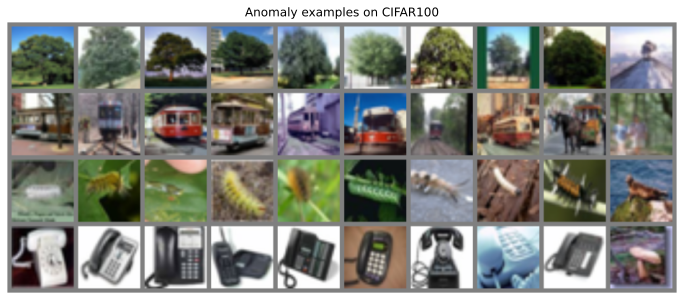

In [55]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS
    
    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

Il est clair que certains ensemble sont plus simples que d'autres.
Après avoir préparé les données, nous pouvons examiner de plus près le modèle. Ici, nous avons une classification de l'ensemble des images. Pour que la prédiction soit équivoque du point de vue de la permutation, nous produirons un logit pour chaque image. Sur ces logits, nous appliquons un softmax et entraînons l'image d'anomalie pour qu'elle ait le score/la probabilité le plus élevé. Cette méthode diffère quelque peu d'une couche de classification standard, car le softmax est appliqué aux images, et non aux classes de sortie au sens classique du terme. Cependant, si nous intervertissons la position de deux images, nous intervertissons effectivement leur position dans le softmax de sortie. La prédiction est donc équivariante par rapport à l'entrée. Nous mettons en œuvre cette idée ci-dessous dans la sous-classe du module Transformer Lightning.

In [56]:
class AnomalyPredictor(TransformerPredictor):
    
    def _calculate_loss(self, batch, mode="train"):
        img_sets, _, labels = batch
        preds = self.forward(img_sets, add_positional_encoding=False) # No positional encodings as it is a set, not a sequence!
        preds = preds.squeeze(dim=-1) # Shape: [Batch_size, set_size]
        loss = F.cross_entropy(preds, labels) # Softmax/CE over set dimension
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc, on_step=False, on_epoch=True)
        return loss, acc
        
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

Enfin, nous écrivons notre fonction d'apprentissage ci-dessous. Elle a exactement la même structure que celle de la tâche inverse.

In [57]:
def train_anomaly(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir, 
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=100,
                         gradient_clip_val=2)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AnomalyPredictor(max_iters=trainer.max_epochs*len(train_anom_loader), **kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    
    # Test best model on validation and test set
    train_result = trainer.test(model, train_anom_loader, verbose=False)
    val_result = trainer.test(model, val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}
    
    model = model.to(device)
    return model, result

Entraînons enfin notre modèle. Nous utiliserons 4 couches avec 4 têtes d'attention chacune. La dimensionnalité cachée du modèle est de 256, et nous utilisons un dropout de 0,1 dans tout le modèle pour une bonne régularisation. Notez que nous appliquons également le dropout sur les caractéristiques d'entrée, car cela rend le modèle plus robuste face au bruit de l'image et permet une meilleure généralisation. Une fois de plus, nous utilisons le warm up pour démarrer lentement l'entraînement de notre modèle. 

In [58]:
anomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.0.2 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\morga\Documents\CN\Cours\DEEP\pres\saved_models\tutorial6\SetAnomalyTask.ckpt`


Found pretrained model, loading...


C:\Users\morga\Documents\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
C:\Users\morga\Documents\anaconda\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

Voici la précision obtenue : 

In [59]:
print(f"Train accuracy: {(100.0*anomaly_result['train_acc']):4.2f}%")
print(f"Val accuracy:   {(100.0*anomaly_result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0*anomaly_result['test_acc']):4.2f}%")

Train accuracy: 96.84%
Val accuracy:   96.78%
Test accuracy:  94.66%


Avec une précision de validation et de test de ~94%, le modèle se généralise assez bien. Nous pouvons conclure que le modèle fonctionne assez bien et peut résoudre la tâche pour la plupart des ensembles. Avant d'essayer d'interpréter le modèle, vérifions que notre modèle est équivariant par permutation, et qu'il attribue les mêmes prédictions pour différentes permutations de l'ensemble d'entrée. Pour ce faire, nous échantillonnons un lot de l'ensemble de test et le soumettons au modèle pour obtenir les probabilités. 

In [60]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)

anomaly_model.eval()

with torch.no_grad():
    preds = anomaly_model.forward(inp_data, add_positional_encoding=False)
    preds = F.softmax(preds.squeeze(dim=-1), dim=-1)

    # Permut input data
    permut = np.random.permutation(inp_data.shape[1])
    perm_inp_data = inp_data[:,permut]
    perm_preds = anomaly_model.forward(perm_inp_data, add_positional_encoding=False)
    perm_preds = F.softmax(perm_preds.squeeze(dim=-1), dim=-1)

assert (preds[:,permut] - perm_preds).abs().max() < 1e-5, "Predictions are not permutation equivariant"

print("Preds\n", preds[0,permut].cpu().numpy())
print("Permuted preds\n", perm_preds[0].cpu().numpy())

Preds
 [9.9942386e-01 5.9920578e-05 5.4598175e-05 6.2115971e-05 8.6624248e-05
 9.0257265e-05 6.4218788e-05 5.7401601e-05 5.3560743e-05 4.7556201e-05]
Permuted preds
 [9.9942374e-01 5.9920570e-05 5.4598171e-05 6.2115905e-05 8.6624234e-05
 9.0257163e-05 6.4218781e-05 5.7401594e-05 5.3560736e-05 4.7556197e-05]


Vous pouvez constater que les prédictions sont presque exactement les mêmes et qu'elles ne diffèrent qu'en raison de légères différences numériques dans le fonctionnement du réseau.

Pour interpréter un peu plus le modèle, nous pouvons tracer les cartes d'attention à l'intérieur du modèle. Cela nous donnera une idée des informations que le modèle partage/communique entre les images et de ce que chaque tête peut représenter. Tout d'abord, nous devons extraire les cartes d'attention pour l'ensemble de tests ci-dessus et déterminer les prédictions discrètes pour plus de simplicité.

In [61]:
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = preds.argmax(dim=-1)

Nous écrivons ci-dessous une fonction de tracé qui représente les images de l'ensemble d'entrée, la prédiction du modèle et les cartes d'attention des différentes têtes sur les couches du transformateur.

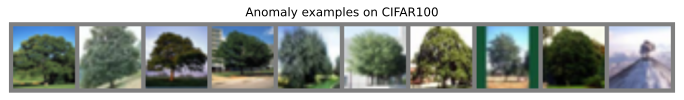

Prediction: 9


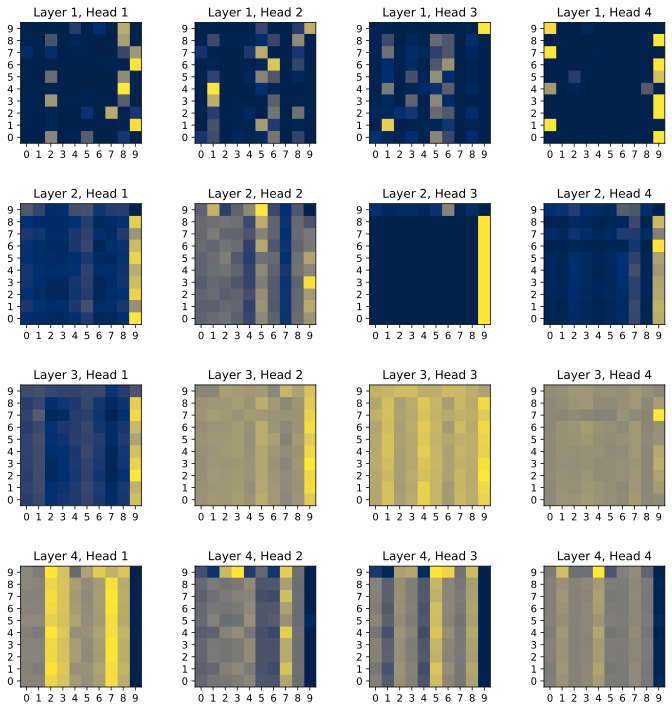

In [63]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

En fonction de la graine aléatoire, vous pouvez voir un ensemble d'entrées légèrement différent. Pour la version du site web, nous comparons 9 images d'arbres avec un volcan. Nous constatons que plusieurs têtes, par exemple la tête 1 de la couche 2, la tête 3 de la couche 2 et la tête 1 de la couche 3, se concentrent sur la dernière image. En outre, les têtes de la couche 4 semblent toutes ignorer la dernière image et lui attribuer une probabilité d'attention très faible. Cela montre que le modèle a effectivement reconnu que l'image ne correspond pas au contexte et a donc prédit qu'il s'agissait d'une anomalie. Couche 3 Tête 2-4 semble prendre une moyenne légèrement pondérée de toutes les images. Cela pourrait indiquer que le modèle extrait l'information "moyenne" de toutes les images, pour la comparer aux caractéristiques de l'image elle-même. 

Essayons de trouver où le modèle commet des erreurs. Nous pouvons le faire en identifiant les ensembles où le modèle prédit autre chose que 9, comme dans l'ensemble de données, nous nous sommes assurés que l'anomalie se trouve toujours à la dernière position de l'ensemble.

In [64]:
mistakes = torch.where(predictions != 9)[0].cpu().numpy()
print("Indices with mistake:", mistakes)

Indices with mistake: [40]


Il n'y a que très peu d'erreurs, visualisons-en une : 

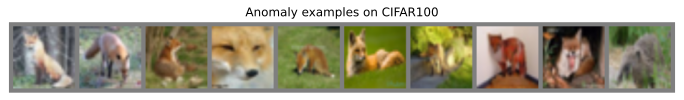

Prediction: 8


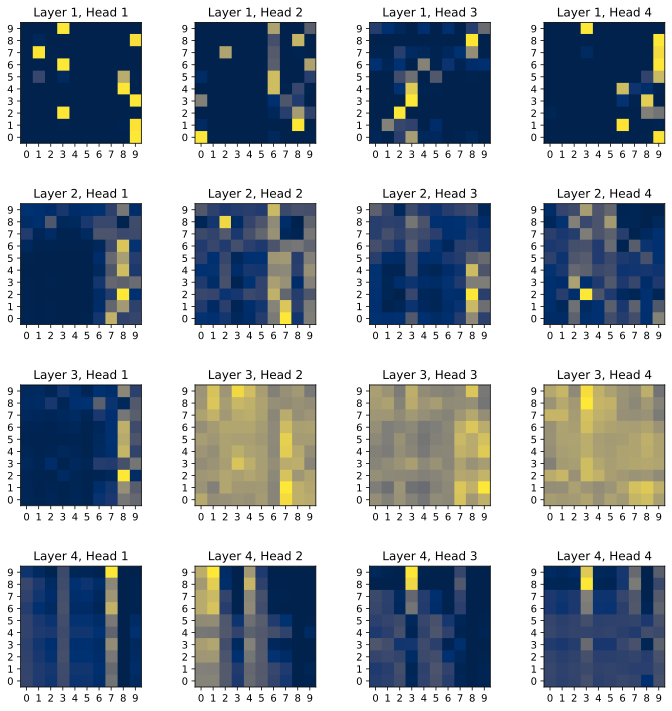

Probabilities:
Image 0: 0.01%
Image 1: 0.01%
Image 2: 0.01%
Image 3: 0.03%
Image 4: 0.01%
Image 5: 0.01%
Image 6: 0.05%
Image 7: 0.06%
Image 8: 99.34%
Image 9: 0.48%


In [65]:
visualize_prediction(mistakes[-1])
print("Probabilities:")
for i, p in enumerate(preds[mistakes[-1]].cpu().numpy()):
    print(f"Image {i}: {100.0*p:4.2f}%")

## Conclusion

Le Transformer est une architecture récente très importante qui peut être appliquée à de nombreuses tâches et ensembles de données. Bien qu'il soit surtout connu pour son succès dans le domaine du NLP, il a beaucoup plus à offrir. Nous avons vu son application à des tâches de séquence à séquence et à la détection d'anomalies dans les ensembles de données. Sa propriété d'être équivariante par permutation si nous ne fournissons pas de codage positionnel lui permet de se généraliser à de nombreux contextes. Il est donc important de connaître l'architecture, mais aussi ses problèmes éventuels, par exemple le problème du gradient pendant les premières itérations, résolu par le warm up.